# Sentiment Analysis for MENTAL HEALTH MONITORING

In [1]:
# 1. Importing Libraries:

# Data handling
import numpy as np
import pandas as pd
from skimpy import skim
import re


# Plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# Text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Missc
from collections import Counter


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Bidirectional
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Tokenize and pad sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## 2. Exploratory Data Analysis

In [2]:
data = pd.read_csv("Combined Data.csv")
data.head()

Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

In [3]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 53043  │ │ string      │ 2     │                                                          │
│ │ Number of columns │ 3      │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA   ┃ NA %   ┃ mean    ┃ sd      ┃ p0  ┃ p25     ┃ p50     ┃ p75     ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Unnamed: 0      │    0 │      0 │   26520 │   15310 │   0 │   13260 │   26520 │   39780 │  53040 │ ▇▇▇▇▇▇  │  │
│ └─────────────────┴──────┴────────┴─────────┴─────────┴─────┴─────────┴─────────┴─────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA       ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ statement                │      362 │       0.68 │                          110 │                  5954845 │  │
│ │ status                   │        0 │          0 │                            1 │                    54244 │  │
│ └──────────────────────────┴──────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

- Checking for null values in the statement column

In [4]:
data[data['statement'].isna()==True].shape

(362, 3)

In [5]:
data.dropna(inplace = True)

In [6]:
data['statement'].isna().unique()

array([False])

In [7]:
data['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [8]:
for x in data['status'].unique():
    print(x, data[data['status']==x].shape[0])

Anxiety 3841
Normal 16343
Depression 15404
Suicidal 10652
Stress 2587
Bipolar 2777
Personality disorder 1077


In [9]:
status_counts = {}

for x in data['status'].unique():
    status_counts[x] = data[data['status']==x].shape[0]

status_counts_sorted = dict(sorted(status_counts.items(), key = lambda item:item[1], reverse = True))

print(status_counts_sorted)

{'Normal': 16343, 'Depression': 15404, 'Suicidal': 10652, 'Anxiety': 3841, 'Bipolar': 2777, 'Stress': 2587, 'Personality disorder': 1077}


| Type                 | Count |
|----------------------|-------|
| Normal               | 16343 |
| Depression           | 15404 |
| Suicidal             | 10652 |
| Anxiety              | 3841  |
| Bipolar              | 2777  |
| Stress               | 2587  |
| Personality disorder | 1077  |

## 2.2 Plotting the 15 most common words in each of these

- First stop words are removed.

Most common words for Anxiety : [('anxiety', 3725), ('like', 3276), ('feel', 2284), ('get', 1984), ('know', 1852), ('time', 1630), ('really', 1603), ('something', 1274), ('back', 1267), ('even', 1223), ('going', 1187), ('go', 1184), ('one', 1179), ('feeling', 1167), ('health', 1153)]


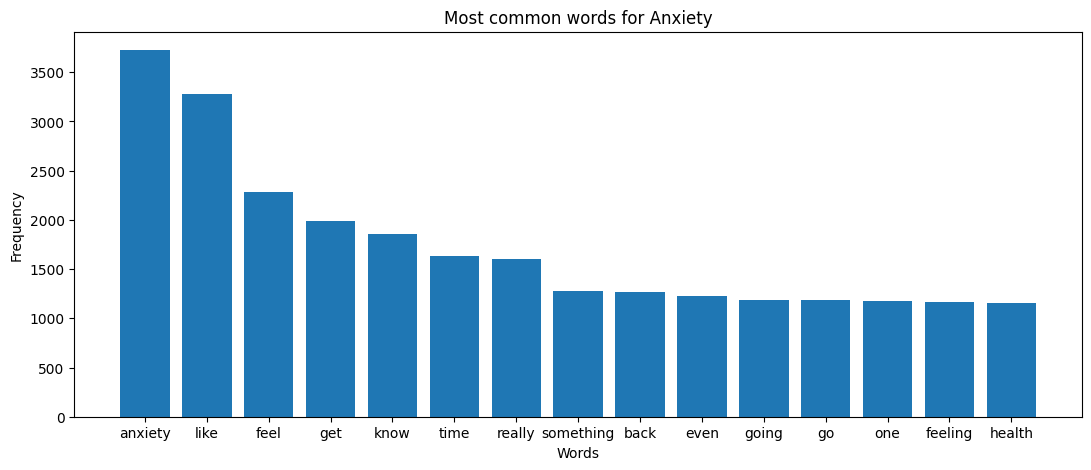

Most common words for Normal : [('like', 1235), ('want', 1120), ('get', 874), ('really', 860), ('time', 809), ('one', 757), ('go', 755), ('know', 736), ('good', 677), ('would', 651), ('people', 643), ('day', 616), ('work', 584), ('going', 561), ('still', 531)]


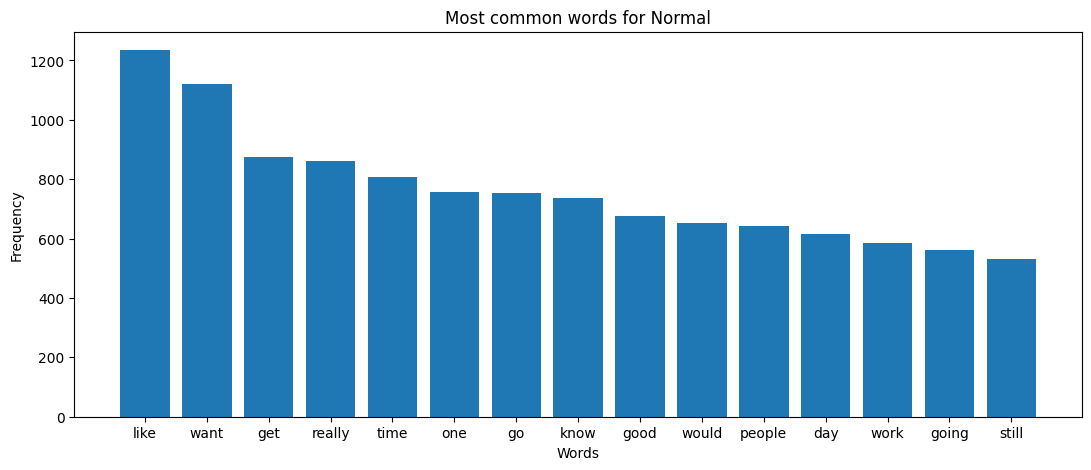

Most common words for Depression : [('like', 18277), ('feel', 16539), ('want', 12124), ('life', 11130), ('know', 10833), ('get', 9992), ('even', 9171), ('time', 8318), ('people', 7903), ('would', 7418), ('really', 7200), ('one', 6398), ('depression', 6378), ('going', 5946), ('day', 5674)]


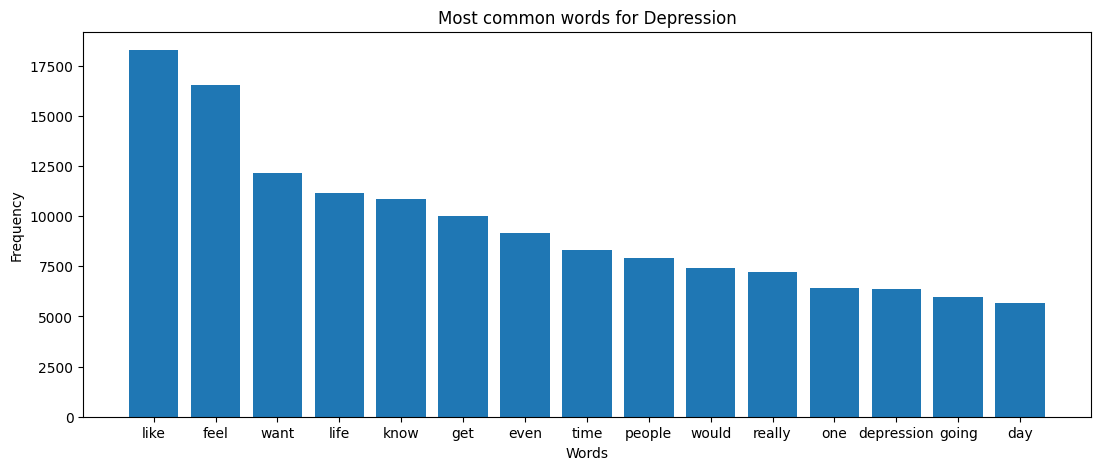

Most common words for Suicidal : [('want', 10640), ('like', 9116), ('life', 7700), ('feel', 7520), ('know', 6545), ('would', 5729), ('get', 5223), ('even', 5180), ('people', 4754), ('anymore', 4416), ('going', 4269), ('time', 4179), ('one', 4144), ('think', 3883), ('really', 3854)]


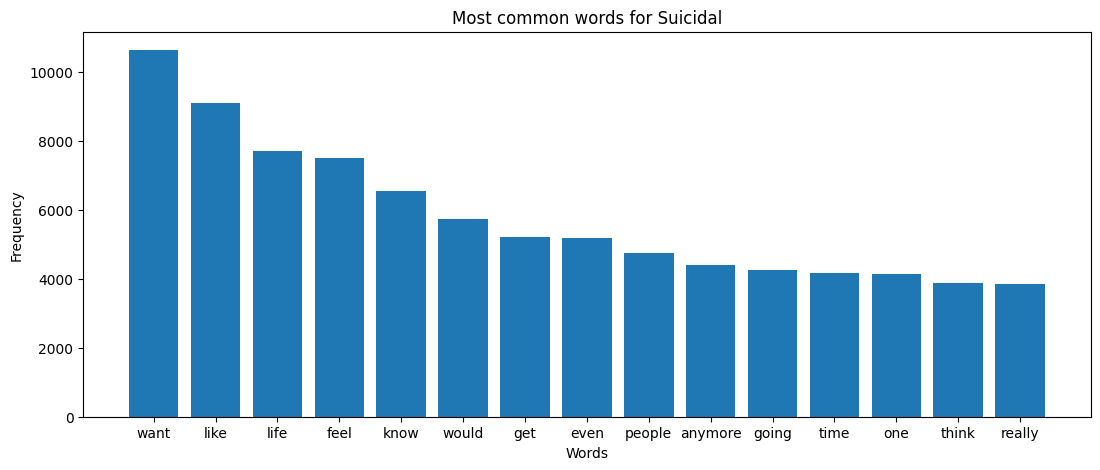

Most common words for Stress : [('like', 1725), ('stress', 1490), ('feel', 1338), ('get', 1207), ('know', 1023), ('time', 1011), ('even', 805), ('work', 790), ('really', 773), ('help', 706), ('life', 654), ('anxiety', 646), ('would', 626), ('want', 623), ('one', 598)]


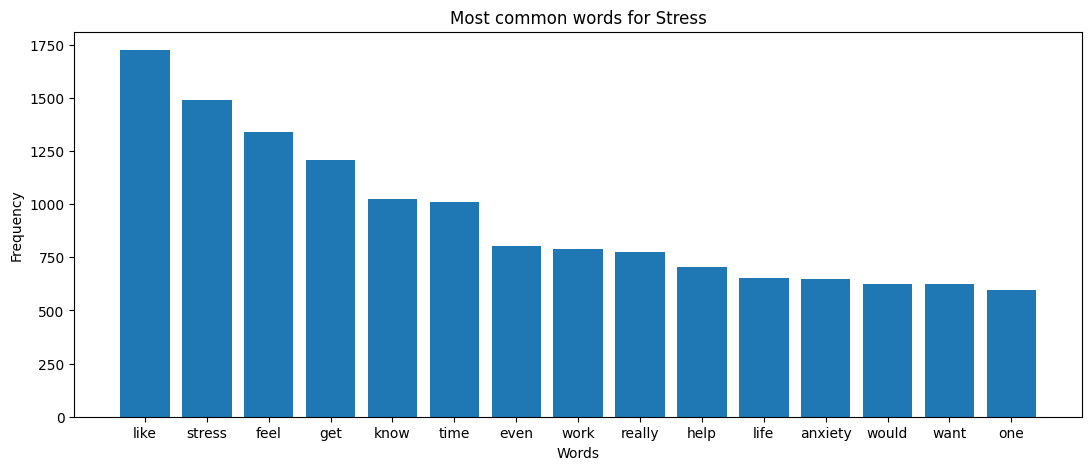

Most common words for Bipolar : [('like', 3028), ('feel', 2388), ('bipolar', 1837), ('get', 1814), ('know', 1787), ('time', 1496), ('really', 1494), ('want', 1306), ('even', 1107), ('life', 1098), ('one', 1075), ('would', 1074), ('anyone', 1025), ('going', 1006), ('people', 981)]


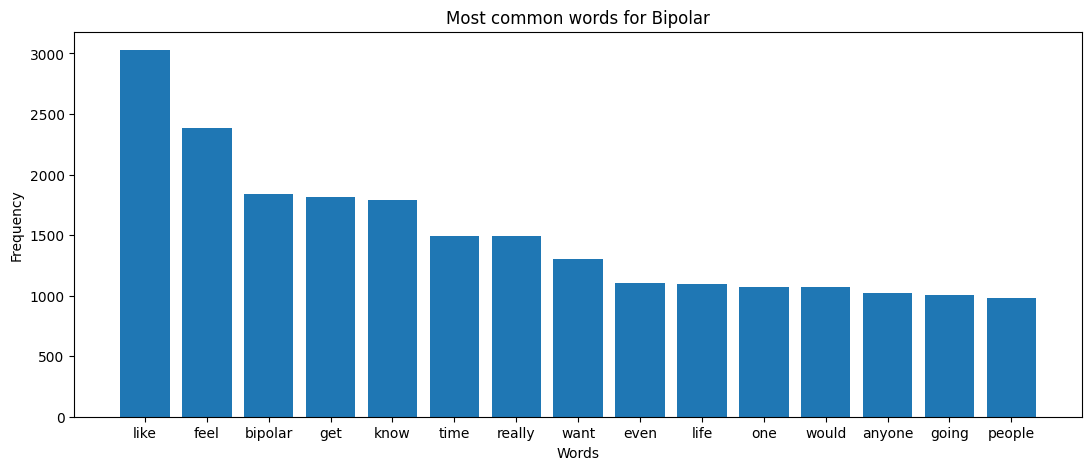

Most common words for Personality disorder : [('like', 1680), ('people', 1248), ('feel', 1101), ('even', 795), ('know', 788), ('get', 637), ('want', 626), ('avpd', 602), ('life', 600), ('really', 596), ('think', 578), ('one', 538), ('time', 522), ('would', 511), ('never', 474)]


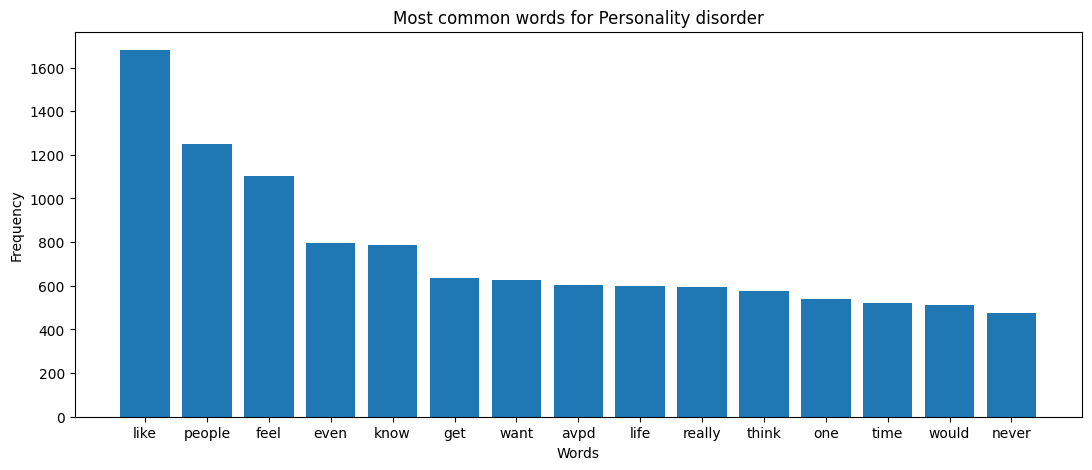

In [10]:
stop_words = set(stopwords.words("english"))

def get_word_freq(status):
    text = " ".join(data[data['status']==status]['statement'])
    words = word_tokenize(text.lower())
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    word_freq = Counter(words_filtered)
    return word_freq

statuses = data['status'].unique()

for status in statuses:
    word_freq = get_word_freq(status)
    most_common_words = word_freq.most_common(15)
    print(f"Most common words for {status} : {most_common_words}")

    word, count = zip(*most_common_words)
    plt.figure(figsize = (13,5))
    plt.bar(word, count)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title(f"Most common words for {status}")
    plt.show()

## Analysis of Most Common Words Across Different Mental Health Conditions

The following is an analysis of the most common words used in statements categorized by various mental health conditions. These insights provide a glimpse into the emotional state and focus of individuals experiencing different conditions.

### 1. **Anxiety**
   - **Top Words**: `anxiety`, `feel`, `know`, `something`
   - **Key Insights**: The word "anxiety" is the most frequently used, indicating that individuals often explicitly mention their anxiety. Words like "feel" and "know" suggest a focus on personal emotions and thoughts. The use of the word "something" could imply uncertainty or vague concerns.

### 2. **Normal**
   - **Top Words**: `like`, `want`, `good`, `day`
   - **Key Insights**: In contrast to the other conditions, the "Normal" category contains more positive and neutral words like "good" and "day." Words like "want" and "like" indicate a focus on desires and preferences rather than emotional distress.

### 3. **Depression**
   - **Top Words**: `feel`, `life`, `depression`, `even`
   - **Key Insights**: The prominence of words like "feel" and "life" suggests that individuals with depression are heavily focused on their internal emotional state and the broader concept of life. The frequent use of the word "depression" indicates that individuals are explicitly naming their condition.

### 4. **Suicidal**
   - **Top Words**: `want`, `life`, `feel`, `anymore`
   - **Key Insights**: The appearance of the word "anymore" signals a loss of hope or a desire for something to end, which aligns with the condition. There is also a strong focus on "life" and "want," reflecting a deep contemplation of existence and desires.

### 5. **Stress**
   - **Top Words**: `stress`, `feel`, `help`, `work`
   - **Key Insights**: "Stress" is directly mentioned, which highlights the specific nature of the concern. The use of words like "help" indicates that individuals are seeking support or relief from their stress. "Work" also appears, suggesting that work-related issues may be a significant source of stress.

### 6. **Bipolar**
   - **Top Words**: `bipolar`, `feel`, `even`, `anyone`
   - **Key Insights**: The word "bipolar" is explicitly mentioned, indicating self-awareness of the condition. Words like "anyone" suggest a potential feeling of isolation or a desire to connect with others who might understand.

### 7. **Personality Disorder**
   - **Top Words**: `people`, `feel`, `avpd`, `never`
   - **Key Insights**: "People" is a frequent word, which could imply a focus on interpersonal relationships or social interactions. The acronym "avpd" refers to `Avoidant Personality Disorder`, indicating specific concerns related to this disorder. The word "never" suggests feelings of hopelessness or permanence.

### General Observations
- **Common Themes**: Across multiple conditions, words like "feel," "like," and "want" appear consistently, which reflects a focus on personal emotions and desires.
- **Specific Words**: Certain conditions feature specific words related to their diagnosis, such as "anxiety," "depression," "bipolar," and "stress," indicating that individuals are explicitly discussing their mental health.
- **Emotional Focus**: The words reveal that individuals often focus on their feelings, their life circumstances, and their interactions with others, which are common threads in mental health discussions.


## 2.3 Word Clouds

In [11]:
def generate_word_clouds(status):
    text = " ".join(data[data['status']==status]['statement'])
    words = word_tokenize(text.lower())
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    text = " ".join(words_filtered)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(13,7))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud : {status}")
    plt.show()

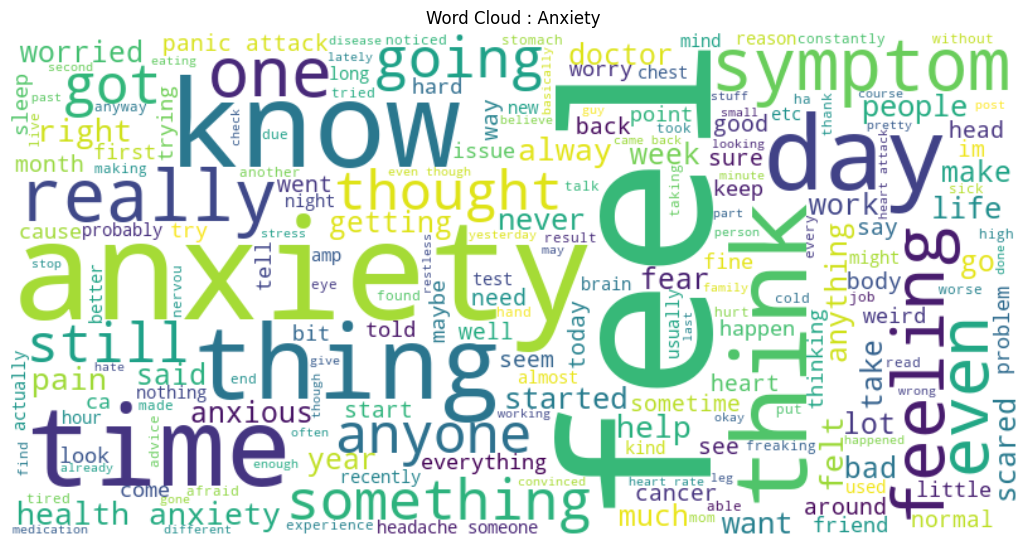

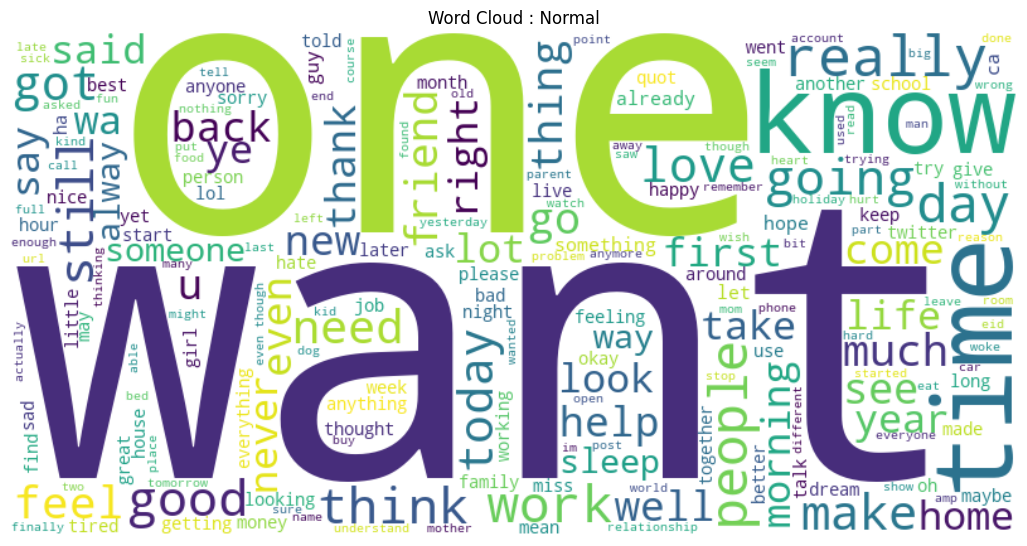

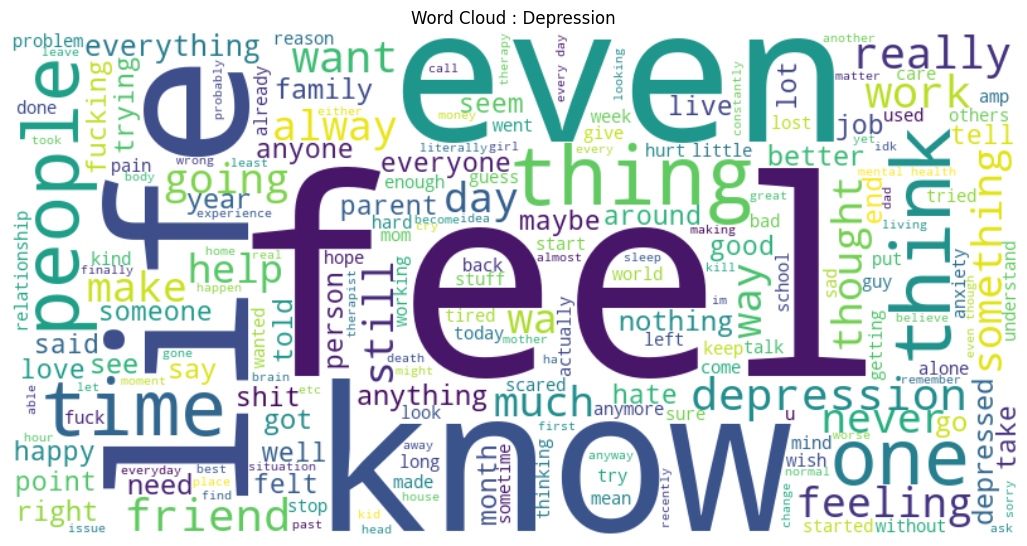

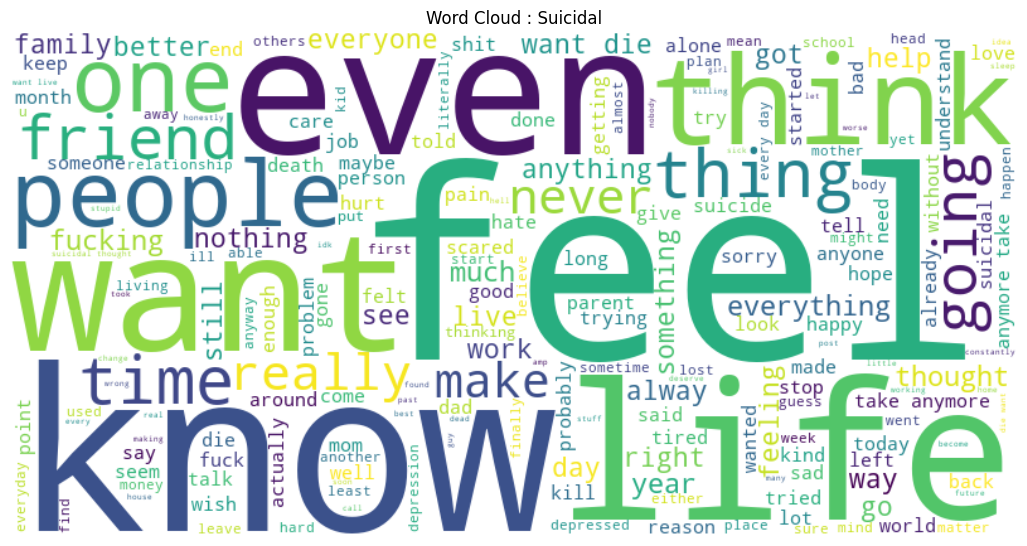

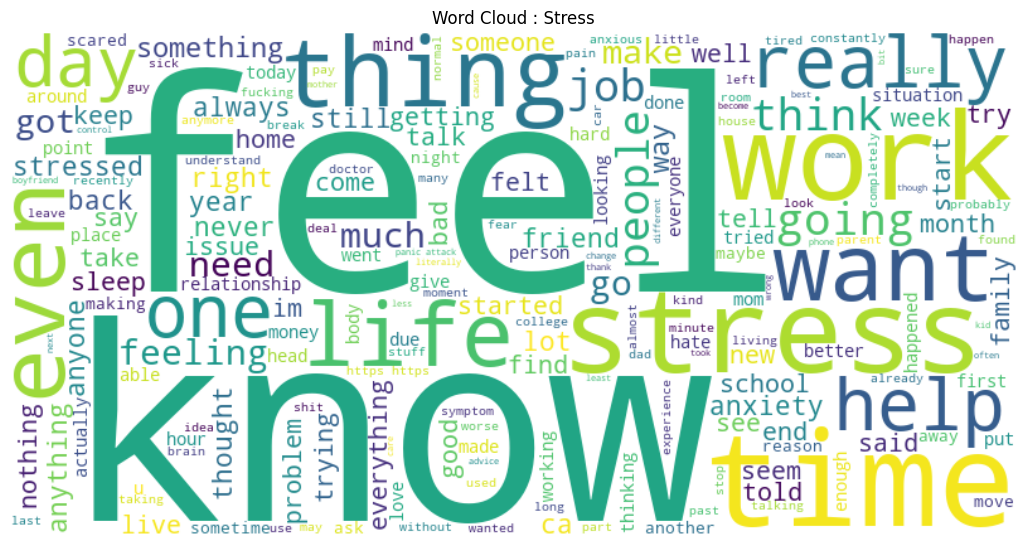

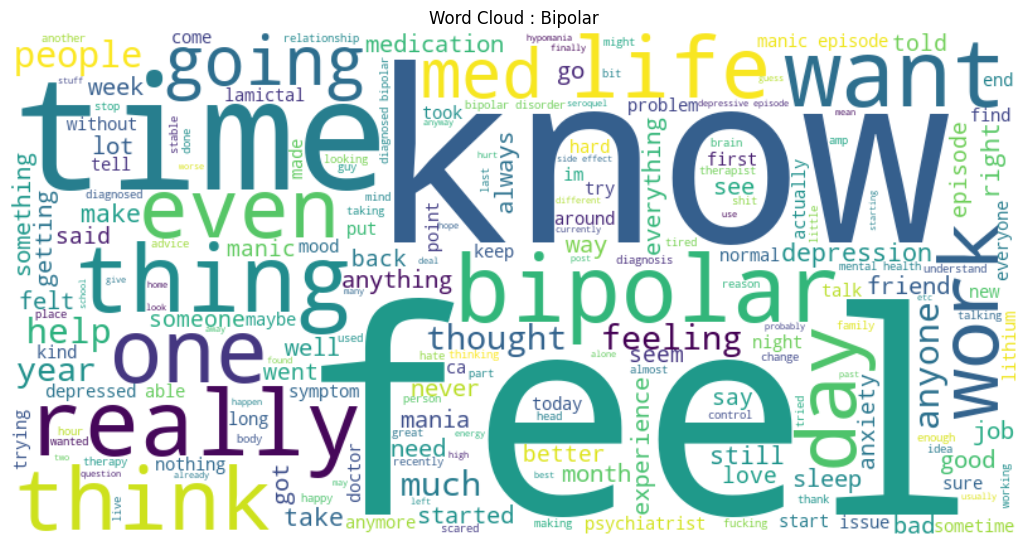

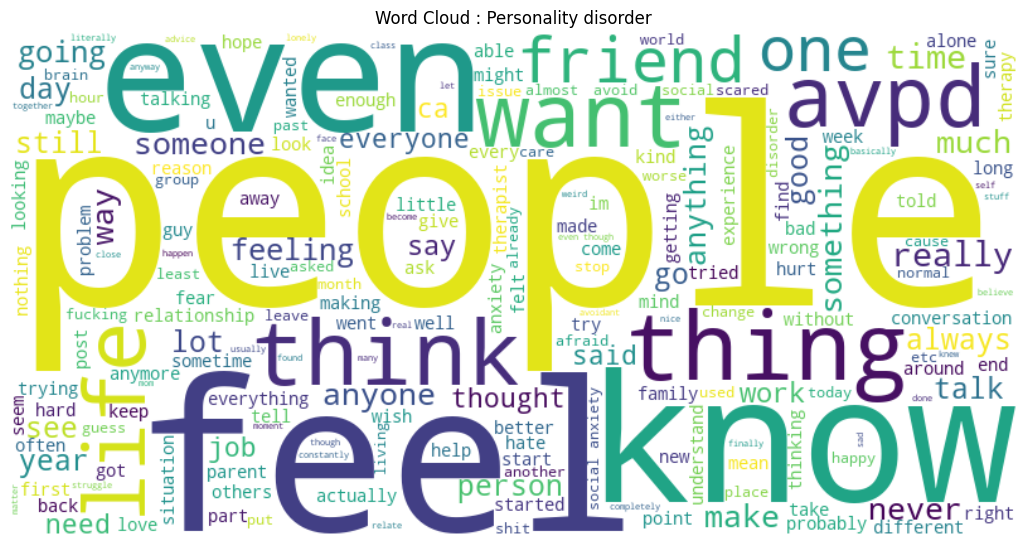

In [ ]:
for status in statuses:
    generate_word_clouds(status)

# Analysis of Mental Health Word Clouds

## Overview
The word clouds represent key terms associated with various mental health conditions:
1. Anxiety
2. Normal (baseline)
3. Depression
4. Suicidal thoughts
5. Stress
6. Bipolar disorder
7. Personality disorder

## Common Themes

Across all conditions, certain words appear frequently:
- "feel/feeling"
- "think/thinking"
- "know"
- "want"
- "time"
- "people"

This suggests that mental health experiences often revolve around cognitive processes, emotions, and social interactions.

## Condition-Specific Insights

### Anxiety
- Dominated by "anxiety", "feel", "think"
- Notable words: "panic", "attack", "scared", "symptom"
- Indicates a focus on physical sensations and worry

### Normal (Baseline)
- More positive terms: "love", "hope", "dream"
- Balanced mix of everyday words
- Less emphasis on extreme emotions or struggles

### Depression
- Key words: "depression", "feel", "know", "want"
- Noteworthy: "never", "nothing", "fucking" (indicating frustration)
- Suggests feelings of hopelessness and negativity

### Suicidal Thoughts
- Prominent: "want", "life", "die"
- Concerning terms: "kill", "suicide", "pain"
- Reflects severe distress and thoughts of self-harm

### Stress
- Centered on "feel", "want", "know"
- Notable: "work", "time", "school"
- Indicates external pressures as major contributors

### Bipolar Disorder
- Key terms: "bipolar", "manic", "depression"
- Unique words: "episode", "medication", "psychiatrist"
- Reflects the cyclical nature of the condition and medical intervention

### Personality Disorder
- Prominent: "feel", "people", "think"
- Specific term: "BPD" (likely Borderline Personality Disorder)
- Suggests interpersonal difficulties and emotional instability

## Implications for NLP and Sentiment Analysis

1. Feature Extraction: Use prominent words as key features for classification models.
2. Emotion Detection: Identify words associated with specific emotional states.
3. Severity Assessment: Analyze word choice to gauge the intensity of mental health challenges.
4. Topic Modeling: Group related terms to identify sub-themes within each condition.
5. Contextual Analysis: Understand the unique linguistic patterns for each mental health state.
6. Intervention Flags: Identify critical terms (e.g., in the suicidal thoughts cloud) for urgent intervention.

# 3. Text Preprocesing
- Tokenization
- Remove punctuation and special characters
- Convert to lowercase
- Remove remaining stop words (if any)
- Stemming or lemmatization

In [12]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    # tokens = [stemmer.stem(token) for token in tokens]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to the 'statement' column
data['processed_statement'] = data['statement'].apply(preprocess_text)

# Display the first few rows to verify
print(data[['statement', 'processed_statement']].head())

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                 processed_statement  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3  ive shifted focus something else im still worried  
4                im restless restless month boy mean  


In [13]:
data.head()

Unnamed: 0                                          statement   status  \
0           0                                         oh my gosh  Anxiety   
1           1  trouble sleeping, confused mind, restless hear...  Anxiety   
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3           3  I've shifted my focus to something else but I'...  Anxiety   
4           4  I'm restless and restless, it's been a month n...  Anxiety   

                                 processed_statement  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3  ive shifted focus something else im still worried  
4                im restless restless month boy mean

In [14]:
data["status"] = data["status"].map({'Anxiety':0, 'Normal':1, 'Depression':2, 'Suicidal':3, 'Stress':4, "Bipolar": 5, "Personality disorder": 6})

| Type                 | Code  |
|----------------------|-------|
| Normal               | 1     |
| Depression           | 2     |
| Suicidal             | 3     |
| Anxiety              | 0     |
| Bipolar              | 5     |
| Stress               | 4     |
| Personality disorder | 6     |

In [15]:
data.head()

Unnamed: 0                                          statement  status  \
0           0                                         oh my gosh       0   
1           1  trouble sleeping, confused mind, restless hear...       0   
2           2  All wrong, back off dear, forward doubt. Stay ...       0   
3           3  I've shifted my focus to something else but I'...       0   
4           4  I'm restless and restless, it's been a month n...       0   

                                 processed_statement  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3  ive shifted focus something else im still worried  
4                im restless restless month boy mean

In [ ]:
train, test = train_test_split(data, test_size = 0.2)

In [ ]:
train.shape

(42144, 4)

In [ ]:
test.shape

(10537, 4)

In [ ]:
data.shape

(52681, 4)

In [ ]:
train.head(2)

Unnamed: 0                                          statement  status  \
23208       23208  9th July 2021 will be my last day alive.Even i...       3   
28484       28484  Because any potential new employer is always g...       4   

                                     processed_statement  
23208  th july last day aliveeven see nobody help hat...  
28484  potential new employer always going ask got ki...

SYNONYMS REPLACEMENT TO  CREATE NEW STATEMENTS.

In [ ]:
pip install nltk textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 3.8 MB/s eta 0:00:00


In [ ]:
from nltk.corpus import wordnet
import random

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.corpus import wordnet

def synonym_replacement(sentence, n_replacements=1):
    """
    Replace n words in the sentence with their synonyms.
    """
    words = sentence.split()
    new_sentence = words.copy()

    # Get synonyms for each word in the sentence
    synonyms = {}
    for word in words:
        syns = wordnet.synsets(word)
        if syns:
            lemmas = [lemma.name().replace('_', ' ') for lemma in syns[0].lemmas()]
            synonyms[word] = set(lemmas)

    # Replace words with their synonyms
    replacements = 0
    while replacements < n_replacements and synonyms:
        word_to_replace = random.choice(list(synonyms.keys()))
        if len(synonyms[word_to_replace]) > 1:
            synonym = random.choice(list(synonyms[word_to_replace] - {word_to_replace}))
            new_sentence = [synonym if word == word_to_replace else word for word in new_sentence]
            replacements += 1
        synonyms.pop(word_to_replace)

    return ' '.join(new_sentence)


In [ ]:
class_counts = {}
for x in train['status'].unique():
    class_counts[x] = train[train['status']==x].shape[0]
    print(x, train[train['status']==x].shape[0])
class_counts

3 8468
4 2099
2 12296
1 13093
0 3089
5 2212
6 887


{3: 8468, 4: 2099, 2: 12296, 1: 13093, 0: 3089, 5: 2212, 6: 887}

In [ ]:
# Classes and their sample sizes
# class_counts = {0: 3076, 1: 12981, 2: 12400, 3: 8530, 4: 2080, 5: 2228, 6: 849}

# Threshold for minority classes (decide based on your data distribution)
threshold = 5000  # Classes below this count are considered minority

# Generate augmented samples for minority classes
augmented_data = []

for label, count in class_counts.items():
    if count < threshold:
        # Filter minority class samples
        minority_data = train[train['status'] == label]

        # Decide the number of new samples to generate
        n_samples_to_generate = threshold - count

        # Generate new augmented samples
        for i in range(n_samples_to_generate):
            sentence = random.choice(minority_data['processed_statement'].tolist())
            new_sentence = synonym_replacement(sentence)
            augmented_data.append({
                'statement': sentence,  # You can keep the original statement or generate new ones
                'processed_statement': new_sentence,
                'status': label
            })

# Convert augmented data to DataFrame and concatenate with original data
augmented_data_df = pd.DataFrame(augmented_data)
train = pd.concat([train, augmented_data_df], ignore_index=True)

print(f"New dataset size after augmentation: {train.shape[0]}")
print(train.head())

New dataset size after augmentation: 53857
   Unnamed: 0                                          statement  status  \
0     23208.0  9th July 2021 will be my last day alive.Even i...       3   
1     28484.0  Because any potential new employer is always g...       4   
2     22786.0  I feel like the more I live and experience lif...       2   
3      2811.0                   YAALLAH SO NATION OF SM DREAMIES       1   
4     23608.0  Very soon I am going to have about 2 hours alo...       3   

                                 processed_statement  
0  th july last day aliveeven see nobody help hat...  
1  potential new employer always going ask got ki...  
2  feel like live experience life reason find add...  
3                         yaallah nation sm dreamies  
4  soon going hour alone think good time die need...  


In [ ]:
augmented_data_df

statement  \
0      xb hey everyone hurricane florence occurred le...   
1      part fear coming back ill find suicide he talk...   
2      work joke around feel ashamed want hear opinio...   
3      yo daughter stressed yo daughter always seemed...   
4      stress lost wallet stress ok goodnight hope fi...   
...                                                  ...   
11708  anyone else hide phone everyone turn televisio...   
11709  anyone lowconfidence anxietydriven mom caretak...   
11710  hollow self life spent largely devoted work mo...   
11711  point trying completely get shit try hard get ...   
11712  dont make decision preference dont know avpd l...   

                                     processed_statement  status  
0      xb hey everyone hurricane florence occurred le...       4  
1      part fear coming back complaint find suicide h...       4  
2      work joke about feel ashamed want hear opinion...       4  
3      yo daughter stressed yo daughter always seemed...       4  
4      stress lost billfold stress ok goodnight hope ...       4  
...                                                  ...     ...  
11708  anyone else hide phone everyone turn televisio...       6  
11709  anyone lowconfidence anxietydriven mom caretak...       6  
11710  hollow self life spent largely devoted work mo...       6  
11711  point trying completely get shit try hard get ...       6  
11712  dont make decision preference dont know avpd l...       6  

[11713 rows x 3 columns]

In [ ]:
for x in train['status'].unique():
    print(x, train[train['status']==x].shape[0])

3 8468
4 5000
2 12296
1 13093
0 5000
5 5000
6 5000


In [ ]:
import random
from nltk.corpus import wordnet
import pandas as pd

# Function to get synonyms
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

# Random Insertion
def random_insertion(sentence, n=2):
    words = sentence.split()
    for _ in range(n):
        new_word = get_synonyms(random.choice(words))
        if new_word:
            random_word = random.choice(new_word)
            random_idx = random.randint(0, len(words))
            words.insert(random_idx, random_word)
    return ' '.join(words)

def random_swap(sentence, n=2):
    words = sentence.split()
    if len(words) < 2: # Check if there are at least two words in the sentence
        return sentence
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Apply augmentation only to minority classes
def augment_data(train, class_labels, augmentation_func, n=1):
    augmented_sentences = []
    for label in class_labels:
        subset = train[train['status'] == label].copy()
        subset['processed_statement'] = subset['processed_statement'].apply(lambda x: augmentation_func(x, n))
        augmented_sentences.append(subset)
    return pd.concat(augmented_sentences, ignore_index=True)

# List of minority class labels
minority_classes = [0, 4, 5, 6]  # 'Anxiety', 'Stress', 'Bipolar', 'Personality disorder'

# Applying augmentations
augmented_data_insertion = augment_data(train, minority_classes, random_insertion, n=2)
augmented_data_swap = augment_data(train, minority_classes, random_swap, n=2)

# Concatenate the augmented data with the original data
train = pd.concat([train, augmented_data_insertion, augmented_data_swap], ignore_index=True)

print(train.head())
print(train.shape[0])

   Unnamed: 0                                          statement  status  \
0     23208.0  9th July 2021 will be my last day alive.Even i...       3   
1     28484.0  Because any potential new employer is always g...       4   
2     22786.0  I feel like the more I live and experience lif...       2   
3      2811.0                   YAALLAH SO NATION OF SM DREAMIES       1   
4     23608.0  Very soon I am going to have about 2 hours alo...       3   

                                 processed_statement  
0  th july last day aliveeven see nobody help hat...  
1  potential new employer always going ask got ki...  
2  feel like live experience life reason find add...  
3                         yaallah nation sm dreamies  
4  soon going hour alone think good time die need...  
93857


In [ ]:
augmented_data_insertion

Unnamed: 0                                          statement  status  \
0         52131.0  Health Anxiety I'm freaking out 😭😭 we're getti...       0   
1         34123.0  Appendicitis? Since I woke up this morning I'v...       0   
2         52115.0  I have anxiety about spending money. So I just...       0   
3         52729.0  I’m so terrified for college and my future. Wh...       0   
4           418.0                                 tired and restless       0   
...           ...                                                ...     ...   
19995         NaN  anyone else hide phone everyone turn televisio...       6   
19996         NaN  anyone lowconfidence anxietydriven mom caretak...       6   
19997         NaN  hollow self life spent largely devoted work mo...       6   
19998         NaN  point trying completely get shit try hard get ...       6   
19999         NaN  dont make decision preference dont know avpd l...       6   

                                     processed_statement  
0      health anxiety im freaking getting renovation ...  
1      appendicitis since woke slope forenoon morning...  
2      anxiety spending money spent bunch money video...  
3      besides im terrified college future im senior ...  
4                       tired tired restless commonplace  
...                                                  ...  
19995  anyone else hide phone everyone sentinel turn ...  
19996  anyone lowconfidence anxietydriven mom caretak...  
19997  hollow self life spent largely devoted work mo...  
19998  point trying completely get shit fourth dimens...  
19999  dont make decision preference dont know avpd l...  

[20000 rows x 4 columns]

In [ ]:
augmented_data_swap

Unnamed: 0                                          statement  status  \
0         52131.0  Health Anxiety I'm freaking out 😭😭 we're getti...       0   
1         34123.0  Appendicitis? Since I woke up this morning I'v...       0   
2         52115.0  I have anxiety about spending money. So I just...       0   
3         52729.0  I’m so terrified for college and my future. Wh...       0   
4           418.0                                 tired and restless       0   
...           ...                                                ...     ...   
19995         NaN  anyone else hide phone everyone turn televisio...       6   
19996         NaN  anyone lowconfidence anxietydriven mom caretak...       6   
19997         NaN  hollow self life spent largely devoted work mo...       6   
19998         NaN  point trying completely get shit try hard get ...       6   
19999         NaN  dont make decision preference dont know avpd l...       6   

                                     processed_statement  
0      health onto im freaking getting renovation don...  
1      appendicitis since woke morning ive strange pa...  
2      anxiety spending money spent bunch money video...  
3      im terrified college future im senior high sch...  
4                                         tired restless  
...                                                  ...  
19995  anyone see hide phone everyone turn first some...  
19996  anyone lowconfidence anxietydriven mom caretak...  
19997  hollow self life spent largely devoted work mo...  
19998  point trying completely work shit try hard get...  
19999  dont make decision preference dont know avpd l...  

[20000 rows x 4 columns]

In [ ]:
for x in train['status'].unique():
    print(x, train[train['status']==x].shape[0])

3 8468
4 15000
2 12296
1 13093
0 15000
5 15000
6 15000


**Data Augmentation using back translation**

In [ ]:
pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=4351cbc687b3814c06a6612291b275f365028f82caab6781fd83acab5d0366d3
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Success

In [ ]:
# from googletrans import Translator

# import time  # To handle retry delays

def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

# # Back translation function with error handling
# def back_translate(sentence, src_lang='en', intermediate_lang='fr', retries=3):
#     translator = Translator()
#     for _ in range(retries):
#         try:
#             # Translate to intermediate language
#             translated = translator.translate(sentence, src=src_lang, dest=intermediate_lang).text
#             # Translate back to source language
#             back_translated = translator.translate(translated, src=intermediate_lang, dest=src_lang).text
#             return back_translated
#         except Exception as e:
#             print(f"Error during translation: {e}. Retrying...")
#             time.sleep(2)  # Wait for 2 seconds before retrying
#     print(f"Failed to translate: {sentence}")
#     return sentence

# # Filter minority classes for augmentation (e.g., status 0, 4, 5, 6)
# minority_classes = [0, 4, 5, 6]
# minority_data = data[data['status'].isin(minority_classes)].copy()

# # Apply back translation to the minority data 'statement' column
# minority_data['augmented_statement'] = minority_data['statement'].apply(lambda x: back_translate(x))

# # Preprocess the back-translated sentences
# minority_data['augmented_processed_statement'] = minority_data['augmented_statement'].apply(preprocess_text)

# # Create a new DataFrame for augmentation
# augmented_data = pd.DataFrame({
#     'statement': minority_data['augmented_statement'],  # Augmented original sentences
#     'processed_statement': minority_data['augmented_processed_statement'],  # Cleaned augmented sentences
#     'status': minority_data['status']  # Corresponding status labels
# })

# # Concatenate with the original data
# data = pd.concat([data, augmented_data], ignore_index=True)

# print(f"New dataset size after augmentation: {data.shape[0]}")
# print(data.head())


from googletrans import Translator
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd

# Initialize the translator once outside the function for reuse
translator = Translator()

def back_translate(sentence, src_lang='en', intermediate_lang='fr'):
    try:
        # Translate to intermediate language
        translated = translator.translate(sentence, src=src_lang, dest=intermediate_lang).text
        # Translate back to source language
        back_translated = translator.translate(translated, src=intermediate_lang, dest=src_lang).text
        return back_translated
    except Exception as e:
        print(f"Error translating sentence: {e}")
        return sentence  # Return the original sentence in case of failure

# Function to handle translation for a batch of sentences
def process_batch(sentences):
    return [back_translate(sentence) for sentence in sentences]

# Set the number of threads you want to use
NUM_THREADS = 8

# Split the minority data into chunks for parallel processing
sentences = minority_data['statement'].tolist()
chunk_size = len(sentences) // NUM_THREADS

# Create chunks
chunks = [sentences[i:i + chunk_size] for i in range(0, len(sentences), chunk_size)]

# Run the translation in parallel
augmented_sentences = []
with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
    # Submit all chunks to be processed in parallel
    futures = {executor.submit(process_batch, chunk): chunk for chunk in chunks}

    for future in as_completed(futures):
        # Collect results from each future
        augmented_sentences.extend(future.result())

# Update the minority data with augmented statements
minority_data['augmented_statement'] = augmented_sentences

# Preprocess the back-translated sentences to remove stop words and clean them up
minority_data['augmented_processed_statement'] = minority_data['augmented_statement'].apply(preprocess_text)

# Concatenate the augmented data back to the original dataset
augmented_data = minority_data[['augmented_processed_statement', 'status']]
augmented_data.rename(columns={'augmented_processed_statement': 'processed_statement'}, inplace=True)
data = pd.concat([data, augmented_data], ignore_index=True)

print(data.head())


Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: <ConnectionTerminated error_code:ErrorCodes.COMPRESSION_ERROR, last_stream_id:9, additional_data:687061636b5f696e76616c69645f696e646578>
Error translating sentence: EOF occurred in violation of protocol (_ssl.c:2426)
Error translating sentence: [SSL: B

In [ ]:
train.shape

(93857, 4)

In [ ]:
train.head(2)

Unnamed: 0                                          statement  status  \
0     23208.0  9th July 2021 will be my last day alive.Even i...       3   
1     28484.0  Because any potential new employer is always g...       4   

                                 processed_statement  
0  th july last day aliveeven see nobody help hat...  
1  potential new employer always going ask got ki...

In [ ]:
test.shape

(10537, 4)

In [ ]:
test.head(2)

Unnamed: 0                                          statement  status  \
29403       29403  I’m so mad. Since April I spoke with four prof...       4   
39771       39771  ya i m gon na to do it tonight it s better for...       2   

                                     processed_statement  
29403  im mad since april spoke four professor course...  
39771              ya gon na tonight better everyone way

In [ ]:
train.iloc[:,-2]

0        3
1        4
2        2
3        1
4        3
        ..
93852    6
93853    6
93854    6
93855    6
93856    6
Name: status, Length: 93857, dtype: int64

In [ ]:
X_train = train.iloc[:, -1]
X_test = test.iloc[:, -1]
y_train = train.iloc[:, -2]
y_test = test.iloc[:, -2]

In [ ]:
X_train.dtype

dtype('O')

In [ ]:
X_test.dtype

dtype('O')

In [ ]:
X_train = X_train.to_frame()
X_test = X_test.to_frame()
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [ ]:
print(X_train.columns)

Index(['processed_statement'], dtype='object')


In [ ]:
y_test.head()

status
29403       4
39771       2
33284       1
3939        1
13474       2

In [ ]:
X_train.shape

(93857, 1)

In [ ]:
X_test.shape

(10537, 1)

In [ ]:
X_test

processed_statement
29403  im mad since april spoke four professor course...
39771              ya gon na tonight better everyone way
33284                                             orange
3939                                ywa nakulbaan jud ko
13474  pain one woman stop dreaming never holding emo...
...                                                  ...
9317   literally time think dying hard actually kill ...
14293  hi everyone hope everyone good day officially ...
40944  abitofdarkness thing depression dont feel sad ...
25143  honestly idea depressed mean depressed extreme...
8385   proud finally got butt back therapy struggling...

[10537 rows x 1 columns]

In [ ]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [ ]:
X_test.shape

(10537, 1)

In [ ]:
# X = data['processed_statement']
X = data.drop(['statement', 'status'], axis=1)
y = data['status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.head()

Unnamed: 0                                processed_statement
56947         NaN  bipolar disorder rarely show alone interesting...
37871     37883.0  enough everything know anymore talk tried end ...
8920       8930.0  sick feeling shit need people keep telling fix...
10318     10328.0  everfeel opposite actually feelingi always bit...
31204     31214.0                                          go church

In [ ]:
y_test.unique().tolist()

[2, 3, 1, 5, 4, 0, 6]

# 4. ML Modeling

### *Count Vectorizer*

In [ ]:
def count_vec_boost(model, text_col, max_df, max_features, ngram_range, n_estimators, max_depth=3, learning_rate=0.03, verbose = False):
    """
    Vectorizes text data using CountVectorizer, trains a classifier model, and evaluates its performance.

    Parameters:
    - model: Classifier model (e.g., XGBoostClassifier, LightGBMClassifier, CatBoostClassifier)
    - text_col: Name of the text column in the dataset
    - max_df: Maximum document frequency threshold for CountVectorizer
    - max_features: Maximum number of features for CountVectorizer
    - ngram_range: Tuple specifying the range of n-grams (e.g., (1, 2) for unigrams and bigrams)
    - stop_words: List of stop words to be removed during vectorization
    - n_estimators: Number of estimators for the classifier model
    - max_depth: Maximum depth of the decision trees (if applicable)
    - learning_rate: Learning rate for gradient boosting classifiers (if applicable)

    Returns:
    - None

    Prints:
    - Classification report showing precision, recall, and F1-score for each class.
    - Confusion matrix visualizing predicted vs. true labels.

    Example usage:
    ```
    vec_pred(RandomForestClassifier, 'text_column', max_df=0.8, max_features=1000, ngram_range=(1, 2),
             stop_words=['english'], n_estimators=100, max_depth=10)
    ```

    """
    best_vectorizer = CountVectorizer(max_df=max_df, max_features=max_features, ngram_range=ngram_range)
    X_train_vector = best_vectorizer.fit_transform(X_train[text_col])
    best_classifier = model(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    best_classifier.fit(X_train_vector, y_train)
    X_test_vector = best_vectorizer.transform(X_test[text_col])
    y_pred = best_classifier.predict(X_test_vector)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    class_labels = y['status'].unique().tolist()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

### *TFIDF Vectorizer*

In [ ]:
# !pip install imblearn

# def tfidf_vec_boost(model, text_col, max_df, max_features, ngram_range, n_estimators, max_depth=3, learning_rate=0.03, verbose = False):
#     """
#     Vectorizes text data using TfidfVectorizer, trains a classifier model, and evaluates its performance.

#     Parameters:
#     - model: Classifier model (e.g., XGBoostClassifier, LightGBMClassifier, CatBoostClassifier)
#     - text_col: Name of the text column in the dataset
#     - max_df: Maximum document frequency threshold for TfidfVectorizer
#     - max_features: Maximum number of features for TfidfVectorizer
#     - ngram_range: Tuple specifying the range of n-grams (e.g., (1, 2) for unigrams and bigrams)
#     - stop_words: List of stop words to be removed during vectorization
#     - n_estimators: Number of estimators for the classifier model
#     - max_depth: Maximum depth of the decision trees (if applicable)
#     - learning_rate: Learning rate for gradient boosting classifiers (if applicable)

#     Returns:
#     - None

#     Prints:
#     - Classification report showing precision, recall, and F1-score for each class.
#     - Confusion matrix visualizing predicted vs. true labels.

#     Example usage:
#     ```
#     vec_boost_tfidf(RandomForestClassifier, 'text_column', max_df=0.8, max_features=1000, ngram_range=(1, 2),
#                     stop_words=['english'], n_estimators=100, max_depth=10)
#     ```
#     """
#     # Vectorize text data using TfidfVectorizer
#     best_vectorizer = TfidfVectorizer(max_df=max_df, max_features=max_features, ngram_range=ngram_range)
#     X_train_vector = best_vectorizer.fit_transform(X_train[text_col])

#     # Initialize and train the classifier model
#     best_classifier = model(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, verbose = verbose)
#     best_classifier.fit(X_train_vector, y_train)

#     # Transform test data using the trained vectorizer
#     X_test_vector = best_vectorizer.transform(X_test[text_col])

#     # Predict test labels
#     y_pred = best_classifier.predict(X_test_vector)

#     # Print classification report
#     print(classification_report(y_test, y_pred))

#     # Compute and plot confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     class_labels = y_test['status'].unique().tolist()
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.show()



from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vec_boost(model, text_col, max_df, max_features, ngram_range, n_estimators, max_depth=3, learning_rate=0.03, verbose=False):
    """
    Vectorizes text data using TfidfVectorizer, applies SMOTE for balancing, trains a classifier model, and evaluates its performance.

    Parameters:
    - model: Classifier model (e.g., XGBoostClassifier, RandomForestClassifier, etc.)
    - text_col: Name of the text column in the dataset
    - max_df: Maximum document frequency threshold for TfidfVectorizer
    - max_features: Maximum number of features for TfidfVectorizer
    - ngram_range: Tuple specifying the range of n-grams (e.g., (1, 2) for unigrams and bigrams)
    - n_estimators: Number of estimators for the classifier model
    - max_depth: Maximum depth of the decision trees (if applicable)
    - learning_rate: Learning rate for gradient boosting classifiers (if applicable)
    - verbose: Whether to print verbose output during model training

    Returns:
    - None

    Prints:
    - Classification report showing precision, recall, and F1-score for each class.
    - Confusion matrix visualizing predicted vs. true labels.
    """
    # Vectorize text data using TfidfVectorizer
    best_vectorizer = TfidfVectorizer(max_df=max_df, max_features=max_features, ngram_range=ngram_range)
    X_train_vector = best_vectorizer.fit_transform(X_train[text_col])

    # Apply SMOTE on the vectorized training data
    # smote = SMOTE()
    smote = SMOTE(sampling_strategy={0: 1000, 3: 3000, 4: 2000})
    X_train_smote, y_train_smote = smote.fit_resample(X_train_vector, y_train)

    # Initialize and train the classifier model
    best_classifier = model(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, verbose=verbose)
    best_classifier.fit(X_train_smote, y_train_smote)

    # Transform test data using the trained vectorizer
    X_test_vector = best_vectorizer.transform(X_test[text_col])

    # Predict test labels
    y_pred = best_classifier.predict(X_test_vector)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    class_labels = y_test['status'].unique().tolist()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


### *Grid Search CV*

In [ ]:
def pipe_boosting(vectorizer, classifier, X_grid, y_grid):
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    hyperparameters = {
        'vectorizer__ngram_range': [(1, 3)],
        'vectorizer__max_df': [1.0],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]}

    grid_search = GridSearchCV(pipeline, hyperparameters, cv=5, n_jobs=-1, verbose=1)

    grid_search.fit(X_grid, y_grid)

    print("Best hyperparameters:", grid_search.best_params_)

### *Predictor*

In [ ]:
def predict_new_text(text, c_vectorizer, model):
    """
    Predicts the category of a given text using the trained vectorizer and model.

    Parameters:
    - text: The input text to be classified
    - c_vectorizer: The trained CountVectorizer or TfidfVectorizer
    - model: The trained classification model

    Returns:
    - dict: The predicted category label and its corresponding index
    """
    # Define the mapping of indices to category labels
    label_mapping = {
        0: 'Anxiety',
        1: 'Normal',
        2: 'Depression',
        3: 'Suicidal',
        4: 'Stress',
        5: 'Bipolar',
        6: 'Personality disorder'
    }

    # Transform the input text using the vectorizer
    text_vector = c_vectorizer.transform([text])

    # Predict the category index
    predicted_index = model.predict(text_vector)[0]

    # Map the predicted index to the category label
    predicted_label = label_mapping[predicted_index]

    return {predicted_label: predicted_index}

### 4.1 Count Vectorization + Model training

In [ ]:
"""%%time
pipe_boosting(vectorizer = CountVectorizer(),
classifier = XGBClassifier(verbose = -1),
X_grid = X_train['statement'],
y_grid = y_train)"""

"%%time\npipe_boosting(vectorizer = CountVectorizer(),\nclassifier = XGBClassifier(verbose = -1),\nX_grid = X_train['statement'],\ny_grid = y_train)"

In [ ]:
best_hyperparameters = {'learning_rate': 0.07, 'n_estimators': 200, 'max_df': 1.0, 'max_features': 10000, 'ngram_range': (1, 3)}


In [ ]:
# prompt: download and import XGBClassifier

!pip install xgboost
from xgboost import XGBClassifier


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.0 MB/s eta 0:00:00


In [ ]:
for x in test['status'].unique():
    print(x, test[test['status']==x].shape[0])

5 559
1 3238
4 544
2 3079
3 2100
0 791
6 226


              precision    recall  f1-score   support

           0       0.72      0.76      0.74       791
           1       0.77      0.92      0.84      3238
           2       0.75      0.61      0.67      3079
           3       0.68      0.54      0.60      2100
           4       0.43      0.62      0.51       544
           5       0.77      0.76      0.77       559
           6       0.49      0.72      0.58       226

    accuracy                           0.71     10537
   macro avg       0.66      0.70      0.67     10537
weighted avg       0.72      0.71      0.71     10537



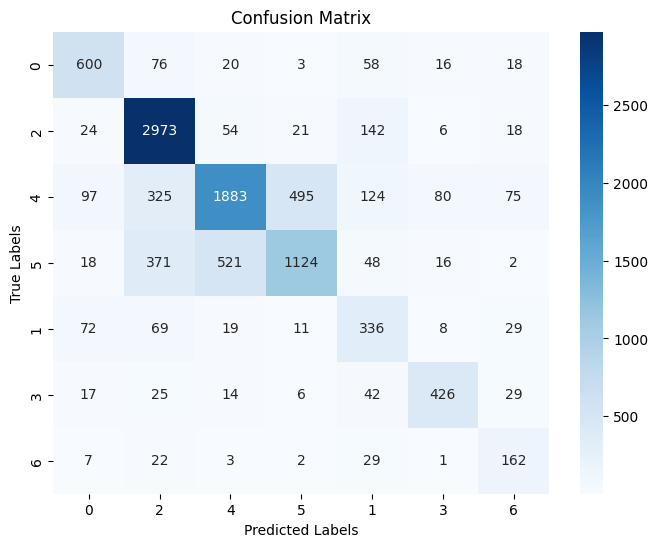

In [ ]:
count_vec_boost(XGBClassifier, "processed_statement", **best_hyperparameters, verbose = False)

              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1198
           1       0.70      0.95      0.81      4102
           2       0.69      0.68      0.68      3820
           3       0.69      0.56      0.62      2723
           4       0.67      0.50      0.57      1213
           5       0.91      0.74      0.82      1250
           6       0.84      0.72      0.78      1294

    accuracy                           0.72     15600
   macro avg       0.75      0.69      0.71     15600
weighted avg       0.73      0.72      0.72     15600



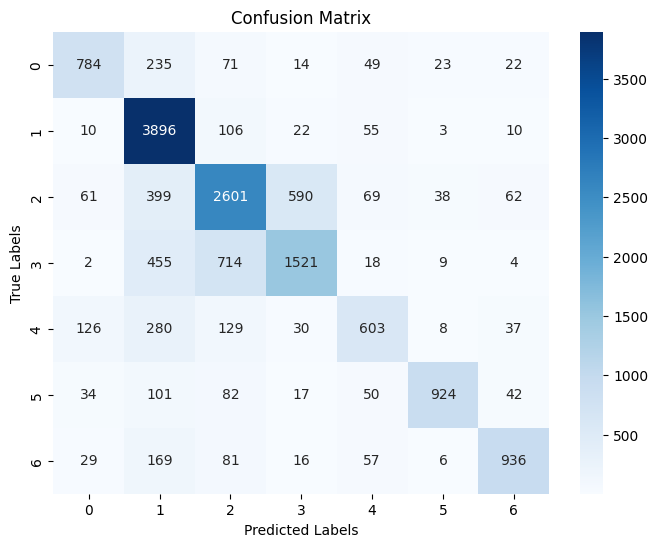

In [ ]:
count_vec_boost(XGBClassifier, "processed_statement", **best_hyperparameters, verbose = False)

In [ ]:
c_vectorizer = CountVectorizer(max_df = 1.0, max_features = 2000, ngram_range = (1, 3))
X_train_vector = c_vectorizer.fit_transform(X_train['processed_statement'])
X_test_vector = c_vectorizer.transform(X_test['processed_statement'])

In [ ]:
model = XGBClassifier(**best_hyperparameters)
model.fit(X_train_vector, y_train)

C:\Users\sushi\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [23:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_df", "max_features", "ngram_range" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_df=1.0,
              max_features=10000, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, n_jobs=None, ...)

In [ ]:
text = data['statement'].sample(1)
text_index = text.index
print(text_index, text.values[0])
text = text.values[0]

Index([25893], dtype='int64') I have always had depression, but over the last few years, I have worked really hard to deal with it. I quit drinking, moved to a new city, made a ton of great new friends, and worked a bunch of part-time jobs that I really loved while pursuing full-time work in my industry. I was always going to concerts, plays, and other fun events. While there were always things that could be better, I kept as busy as I could so that I would not dwell on the negative aspects of life.Then COVID happened and the world shut down. I stopped getting work at most of my jobs, while other jobs went online-only (which I hate). I could barely see my friends for a year and a half. I have not seen my family since December 2019 because they live in another province and travel is restricted.All I have had is alone time. And boy, is it lonely. I have never felt more single in my life. When you strip life down to the bare essentials, you realize how alone you really are. it is not to s

In [ ]:
predict_new_text(text, c_vectorizer, model)

{'Depression': 2}

In [ ]:
data.loc[text_index]['status']

25893    2
Name: status, dtype: int64

### 4.2 TFIDF Vectorization + Model

In [ ]:
# %%time
# pipe_boosting(vectorizer = TfidfVectorizer(),
# classifier = XGBClassifier(verbose = -1),
# X_grid = X_train['processed_statement'],
# y_grid = y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [ ]:
tfidf_vec_boost(XGBClassifier, "processed_statement", 1.0, 2000, (1, 3), 200, 5, 0.07, verbose = False)

ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 15000 samples and 1000 samples are asked.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:41:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.74      0.80      0.77       791
           1       0.82      0.92      0.87      3238
           2       0.75      0.65      0.70      3079
           3       0.68      0.58      0.63      2100
           4       0.46      0.67      0.55       544
           5       0.80      0.79      0.79       559
           6       0.52      0.75      0.62       226

    accuracy                           0.74     10537
   macro avg       0.68      0.74      0.70     10537
weighted avg       0.74      0.74      0.74     10537



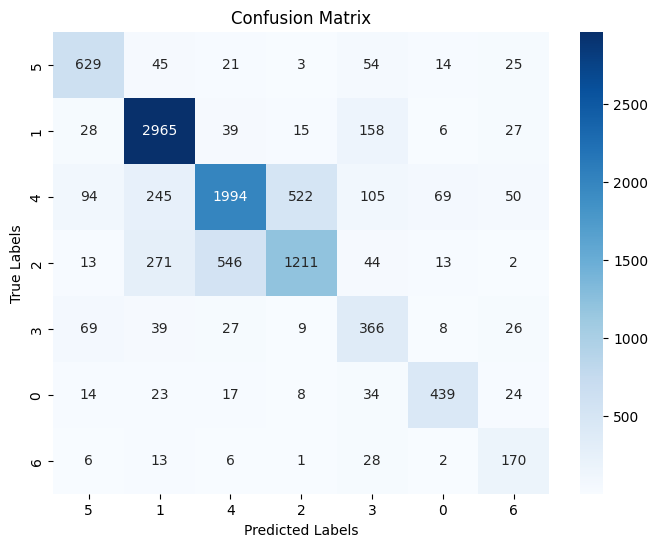

In [ ]:
tfidf_vec_boost(XGBClassifier, "processed_statement", 1.0, 2000, (1, 3), 200, 5, 0.07, verbose = False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:43:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1198
           1       0.78      0.94      0.85      4102
           2       0.71      0.71      0.71      3820
           3       0.70      0.60      0.65      2723
           4       0.74      0.65      0.69      1213
           5       0.92      0.79      0.85      1250
           6       0.87      0.81      0.84      1294

    accuracy                           0.77     15600
   macro avg       0.79      0.75      0.77     15600
weighted avg       0.77      0.77      0.76     15600



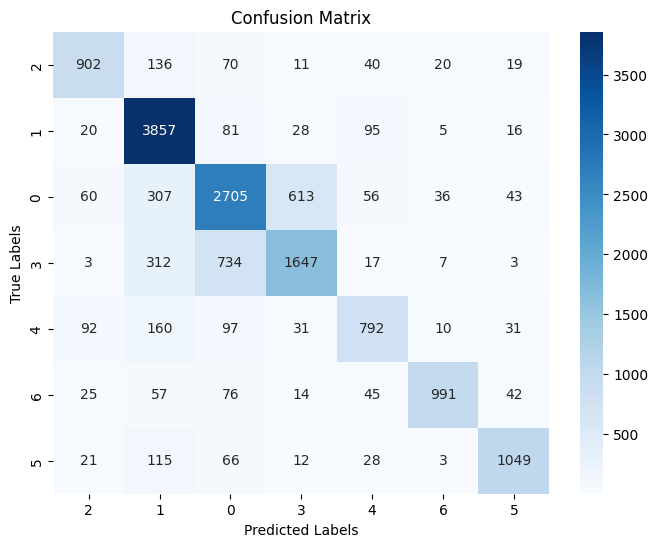

In [ ]:
tfidf_vec_boost(XGBClassifier, "processed_statement", 1.0, 2000, (1, 3), 200, 5, 0.07, verbose = False)

In [ ]:
best_params = {'learning_rate': 0.06, 'n_estimators': 200, 'max_df': 1.0, 'max_features': 2000, 'ngram_range': (1, 3)}

In [ ]:
tfidf_vec_boost(LGBMClassifier, "processed_statement", **best_params, verbose = -1)

In [ ]:
!pip install gensim

In [ ]:
import gensim

In [ ]:
wv_model = gensim.models.Word2Vec(sentences = X_train['processed_statement'], vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
def document_vector(doc):
    doc = [word for word in doc if word in wv_model.wv.key_to_index]
    if len(doc) > 0:
        return np.mean(wv_model.wv[doc], axis = 0)
    else:
        return np.zeros(wv_model.vector_size)

In [ ]:
X_train_vector = X_train['processed_statement'].apply(document_vector)
X_test_vector = X_test['processed_statement'].apply(document_vector)

In [ ]:
!pip install xgboost
from xgboost import XGBClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 4.9 MB/s eta 0:00:00


In [ ]:
# Convert embeddings to numpy arrays
X_train_vector1 = np.array(X_train_vector.tolist())
X_test_vector1 = np.array(X_test_vector.tolist())

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.07)
xgb_model.fit(X_train_vector1, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test_vector1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.44      0.36       767
           1       0.81      0.80      0.80      3298
           2       0.54      0.34      0.42      3126
           3       0.45      0.17      0.25      2043
           4       0.17      0.38      0.23       513
           5       0.21      0.44      0.29       558
           6       0.10      0.47      0.17       232

    accuracy                           0.47     10537
   macro avg       0.37      0.43      0.36     10537
weighted avg       0.54      0.47      0.48     10537



In [ ]:
!pip install gensim tensorflow


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences

In [ ]:
max_length = 100
X_train_seq = pad_sequences(X_train_vector, maxlen=max_length, dtype = 'float')
X_test_seq = pad_sequences(X_test_vector, maxlen=max_length, dtype = 'float')

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train['status'].values), y=y_train['status'].values)
class_weights_dict = dict(enumerate(class_weights))

# Reshape the input data to include the timesteps dimension
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))

model = Sequential()
# Update the input shape to reflect the added timesteps dimension
model.add(LSTM(units=128, input_shape=(max_length, 1), return_sequences = True))
model.add(LSTM(units=256, return_sequences=False))
model.add(Dense(units=7, activation='softmax'))
model.add(Dropout(0.5))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_seq, y_train, epochs=10, batch_size=64, validation_data = (X_test_seq, y_test), class_weight=class_weights_dict)

y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

Epoch 1/10
 165/1467 [==>...........................] - ETA: 5:49 - loss: 8.4325 - accuracy: 0.1472

KeyboardInterrupt: 

In [ ]:
from keras.layers import Bidirectional

# Build Bidirectional LSTM Model
bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(units=128), input_shape=(max_length, 1)))
bi_lstm_model.add(Dense(units=7, activation='softmax'))

bi_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
bi_lstm_model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_data=(X_test_seq, y_test))

# Evaluate model
y_pred_bi = bi_lstm_model.predict(X_test_seq)
y_pred_bi_classes = np.argmax(y_pred_bi, axis=1)

print(classification_report(y_test, y_pred_bi_classes))

Epoch 1/5
1467/1467 [==============================] - 148s 99ms/step - loss: 1.9270 - accuracy: 0.1809 - val_loss: 2.0073 - val_accuracy: 0.1381
Epoch 2/5
1467/1467 [==============================] - 143s 98ms/step - loss: 1.7905 - accuracy: 0.2695 - val_loss: 1.7122 - val_accuracy: 0.3274
Epoch 3/5
1467/1467 [==============================] - 145s 99ms/step - loss: 1.7124 - accuracy: 0.3098 - val_loss: 1.7533 - val_accuracy: 0.3160
Epoch 4/5
1467/1467 [==============================] - 144s 98ms/step - loss: 1.6732 - accuracy: 0.3348 - val_loss: 1.7265 - val_accuracy: 0.3229
Epoch 5/5
330/330 [==============================] - 10s 30ms/step
              precision    recall  f1-score   support

           0       0.19      0.46      0.27       767
           1       0.78      0.70      0.74      3298
           2       0.37      0.07      0.12      3126
           3       0.39      0.02      0.04      2043
           4       0.14      0.11      0.13       513
           5       0.18 

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Build CNN Model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(max_length, 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Flatten())

model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
cnn_model.add(Dense(units=7, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_seq, y_train, epochs=50, batch_size=64, validation_data=(X_test_seq, y_test))

# Evaluate model
y_pred_cnn = cnn_model.predict(X_test_seq)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

print(classification_report(y_test, y_pred_cnn_classes))

Epoch 1/50
1467/1467 [==============================] - 15s 9ms/step - loss: 1.6369 - accuracy: 0.3625 - val_loss: 1.5738 - val_accuracy: 0.3843
Epoch 2/50
1467/1467 [==============================] - 13s 9ms/step - loss: 1.5201 - accuracy: 0.4207 - val_loss: 1.6002 - val_accuracy: 0.3998
Epoch 3/50
1467/1467 [==============================] - 12s 9ms/step - loss: 1.4744 - accuracy: 0.4419 - val_loss: 1.5229 - val_accuracy: 0.4187
Epoch 4/50
1467/1467 [==============================] - 13s 9ms/step - loss: 1.4476 - accuracy: 0.4521 - val_loss: 1.4552 - val_accuracy: 0.4442
Epoch 5/50
1467/1467 [==============================] - 13s 9ms/step - loss: 1.4237 - accuracy: 0.4638 - val_loss: 1.5114 - val_accuracy: 0.4107
Epoch 6/50
1467/1467 [==============================] - 13s 9ms/step - loss: 1.4054 - accuracy: 0.4709 - val_loss: 1.4727 - val_accuracy: 0.4452
Epoch 7/50
1467/1467 [==============================] - 13s 9ms/step - loss: 1.3880 - accuracy: 0.4787 - val_loss: 1.3707 - val_ac

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Build CNN Model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(max_length, 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
model.add(Dropout(0.5))

cnn_model.add(Dense(units=7, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_seq, y_train, epochs=50, batch_size=64, validation_data=(X_test_seq, y_test))

# Evaluate model
y_pred_cnn = cnn_model.predict(X_test_seq)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

print(classification_report(y_test, y_pred_cnn_classes))

Epoch 1/50
1467/1467 [==============================] - 22s 14ms/step - loss: 1.6041 - accuracy: 0.3758 - val_loss: 1.4656 - val_accuracy: 0.4445
Epoch 2/50
1467/1467 [==============================] - 21s 14ms/step - loss: 1.4734 - accuracy: 0.4424 - val_loss: 1.4863 - val_accuracy: 0.4348
Epoch 3/50
1467/1467 [==============================] - 21s 14ms/step - loss: 1.4198 - accuracy: 0.4635 - val_loss: 1.4600 - val_accuracy: 0.4429
Epoch 4/50
1467/1467 [==============================] - 21s 15ms/step - loss: 1.3769 - accuracy: 0.4812 - val_loss: 1.4943 - val_accuracy: 0.4321
Epoch 5/50
1467/1467 [==============================] - 21s 14ms/step - loss: 1.3413 - accuracy: 0.4983 - val_loss: 1.3885 - val_accuracy: 0.4709
Epoch 6/50
1467/1467 [==============================] - 21s 14ms/step - loss: 1.3030 - accuracy: 0.5130 - val_loss: 1.5107 - val_accuracy: 0.4253
Epoch 7/50
1467/1467 [==============================] - 21s 14ms/step - loss: 1.2693 - accuracy: 0.5288 - val_loss: 1.4221 -

In [ ]:
# Build CNN + LSTM Model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(max_length, 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(units=128))
cnn_lstm_model.add(Dense(units=7, activation='softmax'))

cnn_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_lstm_model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_data=(X_test_seq, y_test))

# Evaluate model
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test_seq)

y_pred_cnn_lstm_classes = np.argmax(y_pred_cnn_lstm, axis=1)

print(classification_report(y_test, y_pred_cnn_lstm_classes))


Epoch 1/5
1467/1467 [==============================] - 80s 53ms/step - loss: 1.8014 - accuracy: 0.2452 - val_loss: 1.7238 - val_accuracy: 0.3074
Epoch 2/5
1467/1467 [==============================] - 78s 53ms/step - loss: 1.7398 - accuracy: 0.2800 - val_loss: 1.7894 - val_accuracy: 0.2884
Epoch 3/5
1467/1467 [==============================] - 78s 53ms/step - loss: 1.7028 - accuracy: 0.3079 - val_loss: 1.7663 - val_accuracy: 0.3271
Epoch 4/5
1467/1467 [==============================] - 78s 53ms/step - loss: 1.6621 - accuracy: 0.3366 - val_loss: 1.5983 - val_accuracy: 0.3467
Epoch 5/5
330/330 [==============================] - 6s 17ms/step
              precision    recall  f1-score   support

           0       0.26      0.32      0.28       767
           1       0.75      0.78      0.76      3298
           2       0.45      0.13      0.20      3126
           3       0.39      0.01      0.01      2043
           4       0.11      0.29      0.16       513
           5       0.18      

In [ ]:
# Build the CNN model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# Convolutional Layer 1 with 'same' padding
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))

# Convolutional Layer 2 with 'same' padding
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))

# Convolutional Layer 3 with 'same' padding
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))

# Global Max Pooling instead of MaxPooling1D
model.add(GlobalMaxPooling1D())

# Dropout Layer
model.add(Dropout(dropout_rate))

# Fully Connected Dense Layer
model.add(Dense(dense_units, activation='relu'))

# Another Dropout Layer
model.add(Dropout(dropout_rate))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the Model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the Model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred.argmax(axis=1)))


NameError: name 'num_classes' is not defined

In [ ]:
# Ensure max_len is large enough to handle the layers
max_len = X_train.shape[1]  # Length of padded sequences

# Adjust kernel_size and pool_size to avoid too much downsampling
kernel_size = 3  # Small kernel size
num_filters = 64  # Number of filters for Conv1D layers
dropout_rate = 0.5
dense_units = 128
embedding_dim = 100  # Adjust if necessary based on your Word2Vec embeddings
num_classes = 7

# Build the CNN model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# Convolutional Layer 1 with 'same' padding
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))
# No pooling here to avoid downsampling too early

# Convolutional Layer 2 with 'same' padding
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))

# Convolutional Layer 3 with 'same' padding
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))

# Use GlobalMaxPooling instead of MaxPooling to prevent size issues
model.add(GlobalMaxPooling1D())

# Dropout Layer
model.add(Dropout(dropout_rate))

# Fully Connected Dense Layer
model.add(Dense(dense_units, activation='relu'))

# Another Dropout Layer
model.add(Dropout(dropout_rate))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the Model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the Model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred.argmax(axis=1)))


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1, 100)            6700      
                                                                 
 conv1d_19 (Conv1D)          (None, 1, 64)             19264     
                                                                 
 conv1d_20 (Conv1D)          (None, 1, 64)             12352     
                                                                 
 conv1d_21 (Conv1D)          (None, 1, 64)             12352     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                     

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 7) are incompatible


In [ ]:
print(X_train.shape)

(93939, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'processed_statement' is your text column and 'status' is your label column
# X = data['processed_statement']
# y = data['status']

# Encode labels
# le = LabelEncoder()
# # y_encoded = le.fit_transform(y)
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)

# Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Tokenize and pad sequences
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build LSTM model
model = Sequential([
    Embedding(max_words, 100, input_length=max_len),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

ValueError: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.1`. Either provide more data, or a different value for the `validation_split` argument.

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test accuracy: {accuracy}')

330/330 [==============================] - 16s 47ms/step - loss: 1.0786 - accuracy: 0.7365
Test accuracy: 0.7365474104881287


In [ ]:
from gensim.models import Word2Vec

# Assuming 'data' is your DataFrame and it has been loaded previously
# Ensure the processed_statement column is in the form of tokenized words
sentences = data['processed_statement'].apply(lambda x: x.split())

# Train the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the model for later use
model.save("custom_word2vec.model")

# If you want to access the vector for a specific word
word_vector = model.wv['word']

# You can also print the vocabulary learned by the model
vocab = model.wv.key_to_index
print(vocab)

{'like': 0, 'feel': 1, 'want': 2, 'know': 3, 'get': 4, 'life': 5, 'im': 6, 'time': 7, 'even': 8, 'people': 9, 'would': 10, 'year': 11, 'day': 12, 'really': 13, 'thing': 14, 'one': 15, 'going': 16, 'think': 17, 'go': 18, 'friend': 19, 'make': 20, 'much': 21, 'never': 22, 'help': 23, 'dont': 24, 'feeling': 25, 'could': 26, 'work': 27, 'thought': 28, 'anymore': 29, 'back': 30, 'anxiety': 31, 'take': 32, 'way': 33, 'anything': 34, 'still': 35, 'something': 36, 'depression': 37, 'got': 38, 'good': 39, 'always': 40, 'need': 41, 'anyone': 42, 'everything': 43, 'ive': 44, 'better': 45, 'see': 46, 'every': 47, 'nothing': 48, 'month': 49, 'someone': 50, 'also': 51, 'bad': 52, 'family': 53, 'since': 54, 'hate': 55, 'job': 56, 'say': 57, 'right': 58, 'week': 59, 'last': 60, 'love': 61, 'end': 62, 'live': 63, 'fucking': 64, 'getting': 65, 'keep': 66, 'talk': 67, 'lot': 68, 'die': 69, 'ever': 70, 'care': 71, 'everyone': 72, 'long': 73, 'try': 74, 'person': 75, 'trying': 76, 'point': 77, 'tired': 78,

In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Step 1: Load your Word2Vec model (if you saved it)
from gensim.models import Word2Vec
model = Word2Vec.load("custom_word2vec.model")

# Step 2: Tokenize your data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['processed_statement'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['processed_statement'])

# Pad sequences to ensure uniform input size
max_sequence_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 3: Create the embedding matrix
word_index = tokenizer.word_index
embedding_dim = model.vector_size  # This should match your Word2Vec vector size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]

# Step 4: Build the LSTM model using the embedding matrix
model = Sequential()
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# If you have your labels ready, you can then fit the model
# Assuming you have the labels in y
# model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2520, 100)         7012900   
                                                                 
 lstm (LSTM)                 (None, 2520, 128)         117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7183781 (27.40 MB)
Trainable params: 170881 (667.50 KB)
Non-trainable params: 7012900 (26.75 MB)
_________________________________________________________________


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec

# Assuming 'processed_statement' is your text column and 'status' is your label column
X = train['processed_statement']
y = train['status']

# Encode labels
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.001, random_state=42)

# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Word2Vec Model Training (you already created a Word2Vec model)
# word2vec = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec = Word2Vec(X_train.apply(lambda x: x.split()), vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

# Build the Bidirectional LSTM Model
model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1],
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),  # Use pre-trained embeddings
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test accuracy: {accuracy}')

# Make predictions and generate classification report
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)  # Get the class with the highest probability

# Generate classification report
report = classification_report(y_test, y_pred_classes)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)


Epoch 1/10
2640/2640 [==============================] - 369s 138ms/step - loss: 1.0511 - accuracy: 0.7352 - val_loss: 0.7416 - val_accuracy: 0.8052
Epoch 2/10
2640/2640 [==============================] - 362s 137ms/step - loss: 0.7116 - accuracy: 0.8200 - val_loss: 0.6527 - val_accuracy: 0.8278
Epoch 3/10
2640/2640 [==============================] - 362s 137ms/step - loss: 0.6317 - accuracy: 0.8457 - val_loss: 0.5865 - val_accuracy: 0.8571
Epoch 4/10
2640/2640 [==============================] - 362s 137ms/step - loss: 0.5840 - accuracy: 0.8603 - val_loss: 0.5692 - val_accuracy: 0.8574
Epoch 5/10
2640/2640 [==============================] - 362s 137ms/step - loss: 0.5521 - accuracy: 0.8688 - val_loss: 0.5471 - val_accuracy: 0.8679
Epoch 6/10
2640/2640 [==============================] - 363s 137ms/step - loss: 0.5313 - accuracy: 0.8775 - val_loss: 0.5496 - val_accuracy: 0.8711
Epoch 7/10
2640/2640 [==============================] - 362s 137ms/step - loss: 0.5190 - accuracy: 0.8809 - val_

ValueError: Data cardinality is ambiguous:
  x sizes: 1
  y sizes: 10537
Make sure all arrays contain the same number of samples.

# **BEST MODEL EVER!!! THE GREATEST OF ALL TIME!!! **

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec

In [ ]:
X = train['processed_statement']
y = train['status']

# Encode labels
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# Split the data
# X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.001, random_state=42)

# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
X_train.shape

(93857,)

In [ ]:
X_train.dtype

dtype('O')

In [ ]:
X_test.dtype

dtype('O')

In [ ]:
X_test_pad.shape

(10537, 100)

In [ ]:
X_test_seq

In [ ]:
X_test.shape

(10537,)

In [ ]:
X_test1.shape

(94,)

In [ ]:
X_test1

30479    depression damn brutal add top ugly virgin ext...
91963    anyone else keep making new reddit account fin...
20683    masha allah dey wait make someone tweet icing ...
38804                                              lay lay
41327    kill go work tomorrowif kill deal financial st...
                               ...                        
53120    idk fit decided share treat nicely seems fake ...
32830    llama shush little child cry matter much wish ...
78819    many love worried much losing fallen believe clip
91498    anybody mainly scared simply perceived like do...
10405    swimming swimming swimming one day finally sto...
Name: processed_statement, Length: 94, dtype: object

In [ ]:
word2vec = Word2Vec(X_train.apply(lambda x: x.split()), vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

# Build the Bidirectional LSTM Model
model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1],
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),  # Use pre-trained embeddings
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          6392900   
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 256)          234496    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test accuracy: {accuracy}')

# Make predictions and generate classification report
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)  # Get the class with the highest probability

# Generate classification report
report = classification_report(y_test, y_pred_classes)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec

# You can skip the data splitting and oversampling steps since you already have X_train, X_test, y_train, and y_test
# Assuming X_train, X_test, y_train, y_test are already available

# Tokenize and pad sequences (assuming you have already tokenized the data)
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Word2Vec Model Training (you already created a Word2Vec model)
word2vec = Word2Vec(X_train.apply(lambda x: x.split()), vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

# Build the Bidirectional LSTM Model
model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1],
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),  # Use pre-trained embeddings
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Assuming 7 classes (0-6)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test accuracy: {accuracy}')

# Make predictions and generate classification report
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)  # Get the class with the highest probability

# Generate classification report
report = classification_report(y_test, y_pred_classes)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)


In [ ]:
target_names = le.classes_.astype(str).tolist()


In [ ]:
# Assuming y_test and y_pred_classes are defined
report = classification_report(y_test, y_pred_classes, target_names=target_names)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       755
           1       0.86      0.96      0.90      3308
           2       0.68      0.77      0.72      3016
           3       0.73      0.52      0.61      2158
           4       0.55      0.51      0.53       536
           5       0.81      0.69      0.75       527
           6       0.67      0.46      0.55       237

    accuracy                           0.76     10537
   macro avg       0.72      0.68      0.69     10537
weighted avg       0.75      0.76      0.75     10537

